# Targeting Direct Marketing with Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_


## Background
Direct marketing, either through mail, email, phone, etc., is a common tactic to acquire customers.  Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer.  Predicting those potential customers based on readily available information like demographics, past interactions, and environmental factors is a common machine learning problem.

This notebook presents an example problem to predict if a customer will enroll for a term deposit at a bank, after one or more phone calls.  The steps include:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [28]:
# Import the latest sagemaker and boto3 SDKs
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=2.0.0" tqdm
!{sys.executable} -m pip show sagemaker


Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.2.3)
Name: sagemaker
Version: 2.13.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: google-pasta, boto3, protobuf3-to-dict, protobuf, numpy, importlib-metadata, smdebug-rulesconfig, packaging
Required-by: 


In [29]:
bucket = 'aimlbb-saichan'
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role
import boto3
import re


from sagemaker import get_execution_role

role = get_execution_role()

Now let's bring in the Python libraries that we'll use throughout the analysis

In [30]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
# Converts strings for HTTP POST requests on inference
! python -m pip install smdebug  

---

## Data
Let's start by downloading the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket. 

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


In [31]:
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!apt-get install unzip -y
!unzip -o bank-additional.zip

--2020-10-03 14:26:57--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.220.1
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.220.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip.3’

bank-additional.zip 100%[===================>] 422.68K  --.-KB/s    in 0.008s  

2020-10-03 14:26:57 (48.7 MB/s) - ‘bank-additional.zip.3’ saved [432828/432828]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-23+deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Archive:  bank-additional.zip
  inflating: bank-ad

Now lets read this into a Pandas data frame and take a look.

In [32]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv')


Let's talk about the data.  At a high level, we can see:

* We have a little over 40K customer records, and 20 features for each customer
* The features are mixed; some numeric, some categorical
* The data appears to be sorted, at least by `time` and `contact`, maybe more

_**Specifics on each of the features:**_

*Demographics:*
* `age`: Customer's age (numeric)
* `job`: Type of job (categorical: 'admin.', 'services', ...)
* `marital`: Marital status (categorical: 'married', 'single', ...)
* `education`: Level of education (categorical: 'basic.4y', 'high.school', ...)

*Past customer events:*
* `default`: Has credit in default? (categorical: 'no', 'unknown', ...)
* `housing`: Has housing loan? (categorical: 'no', 'yes', ...)
* `loan`: Has personal loan? (categorical: 'no', 'yes', ...)

*Past direct marketing contacts:*
* `contact`: Contact communication type (categorical: 'cellular', 'telephone', ...)
* `month`: Last contact month of year (categorical: 'may', 'nov', ...)
* `day_of_week`: Last contact day of the week (categorical: 'mon', 'fri', ...)
* `duration`: Last contact duration, in seconds (numeric). Important note: If duration = 0 then `y` = 'no'.
 
*Campaign information:*
* `campaign`: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* `pdays`: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* `previous`: Number of contacts performed before this campaign and for this client (numeric)
* `poutcome`: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

*External environment factors:*
* `emp.var.rate`: Employment variation rate - quarterly indicator (numeric)
* `cons.price.idx`: Consumer price index - monthly indicator (numeric)
* `cons.conf.idx`: Consumer confidence index - monthly indicator (numeric)
* `euribor3m`: Euribor 3 month rate - daily indicator (numeric)
* `nr.employed`: Number of employees - quarterly indicator (numeric)

*Target variable:*
* `y`: Has the client subscribed a term deposit? (binary: 'yes','no')

### Transformation

Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

* Handling missing values: Some machine learning algorithms are capable of handling missing values, but most would rather not.  Options include:
 * Removing observations with missing values: This works well if only a very small fraction of observations have incomplete information.
 * Removing features with missing values: This works well if there are a small number of features which have a large number of missing values.
 * Imputing missing values: Entire [books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
* Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* Oddly distributed data: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.  These buckets can then be treated as categorical variables and included in the model when one hot encoded.
* Handling more complicated data types: Mainpulating images, text, or data at varying grains is left for other notebook templates.

Luckily, some of these aspects have already been handled for us, and the algorithm we are showcasing tends to do well at handling sparse or oddly distributed data.  Therefore, let's keep pre-processing simple.

In [33]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)                                                                  # Convert categorical variables to sets of indicators

Another question to ask yourself before building a model is whether certain features will add value in your final use case.  For example, if your goal is to deliver the best prediction, then will you have access to that data at the moment of prediction?  Knowing it's raining is highly predictive for umbrella sales, but forecasting weather far enough out to plan inventory on umbrellas is probably just as difficult as forecasting umbrella sales without knowledge of the weather.  So, including this in your model may give you a false sense of precision.

Following this logic, let's remove the economic features and `duration` from our data as they would need to be forecasted with high precision to use as inputs in future predictions.

Even if we were to use values of the economic indicators from the previous quarter, this value is likely not as relevant for prospects contacted early in the next quarter as those contacted later on.

In [34]:
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

When building a model whose primary goal is to predict a target value on new data, it is important to understand overfitting.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.

The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on "new" data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [35]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [36]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [37]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [63]:
#from sagemaker.amazon.amazon_estimator import get_image_uri
#container = get_image_uri(boto3.Session().region_name,'xgboost', '0.90-2')
from sagemaker.image_uris import retrieve
container = retrieve(framework='xgboost',region=boto3.Session().region_name, version='0.90-2')


Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [64]:
from sagemaker.inputs import TrainingInput
#s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
#s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [45]:
base_job_name = "demo-smdebug-xgboost-regression"
bucket_path='s3://{}/{}/output'.format(bucket, prefix)

### Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convinient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [49]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator
sess = sagemaker.Session()

save_interval = 5 

xgboost_estimator = Estimator(container,
    role=role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type='ml.m5.4xlarge',
    
    max_run=1800,
    sagemaker_session=sess,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="predictions",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            )
        ],
    )
)

In [50]:
xgboost_estimator.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [51]:

xgboost_estimator.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    # This is a fire and forget event. By setting wait=False, you submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False
)

### Result

As a result of the above command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if `train-rmse` and `validation-rmse` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

**Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says Rule Evaluation Status is Started, and shows the `RuleEvaluationJobArn`, you can look at the status of the rule being monitored.**

In [52]:
import time
from time import gmtime, strftime


# Below command will give the status of training job
job_name = xgboost_estimator.latest_training_job.name
client = xgboost_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
print('Training job name: ' + job_name)
print(description['TrainingJobStatus'])

if description['TrainingJobStatus'] != 'Completed':
    while description['SecondaryStatus'] not in ['Training', 'Completed']:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description['TrainingJobStatus']
        secondary_status = description['SecondaryStatus']
        print("{}: {}, {}".format(strftime('%X', gmtime()), primary_status, secondary_status))
        time.sleep(15)

Training job name: demo-smdebug-xgboost-regression-2020-10-03-14-40-49-497
InProgress
14:41:00: InProgress, Starting
14:41:15: InProgress, Starting
14:41:30: InProgress, Starting
14:41:45: InProgress, Starting
14:42:00: InProgress, Starting
14:42:15: InProgress, Starting
14:42:30: InProgress, Starting
14:42:45: InProgress, Downloading
14:43:00: InProgress, Downloading
14:43:16: InProgress, Training


## Data Analysis - Manual

Now that you've trained the system, analyze the data.
Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

In [65]:
from smdebug.trials import create_trial

description = client.describe_training_job(TrainingJobName=job_name)
s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()

# This is where we create a Trial object that allows access to saved tensors.
trial = create_trial(s3_output_path)

[2020-10-03 14:48:49.782 datascience-1-0-ml-m5-8xlarge-ef5e793c28e1fac85f5e3835e843:37 INFO s3_trial.py:42] Loading trial debug-output at path s3://aimlbb-saichan/sagemaker/DEMO-xgboost-dm/output/demo-smdebug-xgboost-regression-2020-10-03-14-40-49-497/debug-output


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [66]:
trial.tensor_names()

[2020-10-03 14:48:53.940 datascience-1-0-ml-m5-8xlarge-ef5e793c28e1fac85f5e3835e843:37 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-10-03 14:48:54.956 datascience-1-0-ml-m5-8xlarge-ef5e793c28e1fac85f5e3835e843:37 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f21',
 'average_shap/f22',
 'average_shap/f23',
 'average_shap/f24',
 'average_shap/f25',
 'average_shap/f26',
 'average_shap/f27',
 'average_shap/f28',
 'average_shap/f29',
 'average_shap/f3',
 'average_shap/f30',
 'average_shap/f31',
 'average_shap/f32',
 'average_shap/f33',
 'average_shap/f34',
 'average_shap/f35',
 'average_shap/f36',
 'average_shap/f37',
 'average_shap/f38',
 'average_shap/f39',
 'average_shap/f4',
 'average_shap/f40',
 'average_shap/f41',
 'average_shap/f42',
 'average_shap/f43',
 'average_shap/f44',
 'average_shap/f45',
 'average_shap/f46',
 'average_shap/f47',
 'average_shap/f48',
 'average_shap/f49',
 'average_shap/f5',
 'average_shap/f50',
 'average_shap/f51'

For each tensor, ask for the steps where you have data. In this case, every five steps

In [67]:
trial.tensor("predictions").values()

{0: array([0.40940192, 0.40940192, 0.40940192, ..., 0.42072025, 0.42072025,
        0.40940192], dtype=float32),
 5: array([0.17423216, 0.17423216, 0.17423216, ..., 0.20525002, 0.20525002,
        0.17011178], dtype=float32),
 10: array([0.09244758, 0.09244758, 0.09244758, ..., 0.14336592, 0.1304271 ,
        0.08529319], dtype=float32),
 15: array([0.06389849, 0.05903047, 0.06389849, ..., 0.11248846, 0.10763057,
        0.0549309 ], dtype=float32),
 20: array([0.05420081, 0.05003211, 0.05420081, ..., 0.09846841, 0.10812173,
        0.0407625 ], dtype=float32),
 25: array([0.04791263, 0.03964589, 0.0486064 , ..., 0.09368774, 0.10400326,
        0.03752989], dtype=float32),
 30: array([0.04766197, 0.06056261, 0.04844233, ..., 0.09047107, 0.0994751 ,
        0.0341584 ], dtype=float32),
 35: array([0.0499336 , 0.05720866, 0.04722781, ..., 0.08356649, 0.09964165,
        0.03486255], dtype=float32),
 40: array([0.05173785, 0.05747067, 0.04266172, ..., 0.08261214, 0.09674504,
        0.034

You can obtain each tensor at each step as a NumPy array.

In [68]:
type(trial.tensor("predictions").value(10))

numpy.ndarray

### Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
Each gradient should get smaller over time, as the system converges to a good solution.
Remember that this is an interactive analysis. You are showing these tensors to give an idea of the data.

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

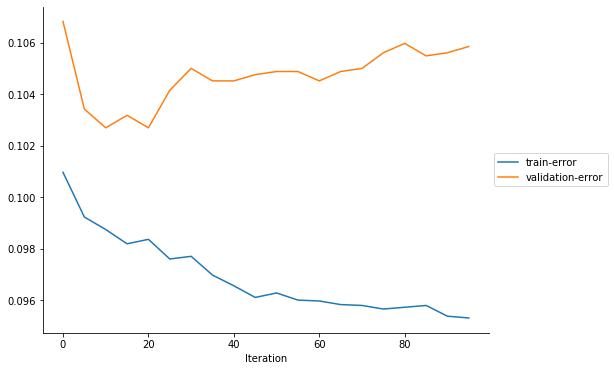

In [70]:
plot_collection(trial, "metrics")

### Feature importances

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all five importance types supported by `xgboost.get_score()` will be available in the collection.

In [71]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

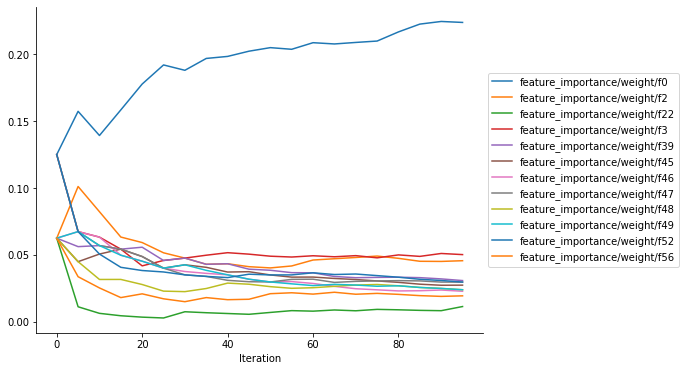

In [72]:
plot_feature_importance(trial)

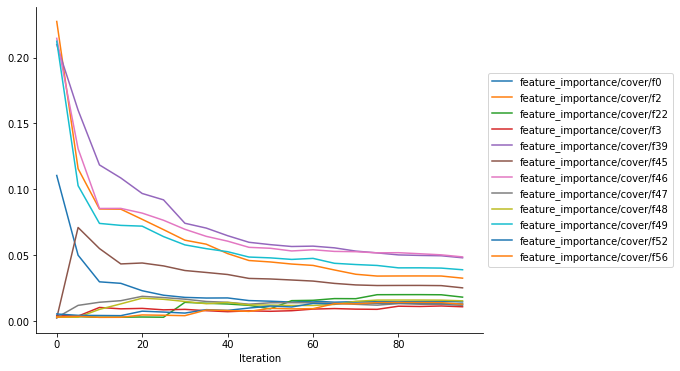

In [73]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

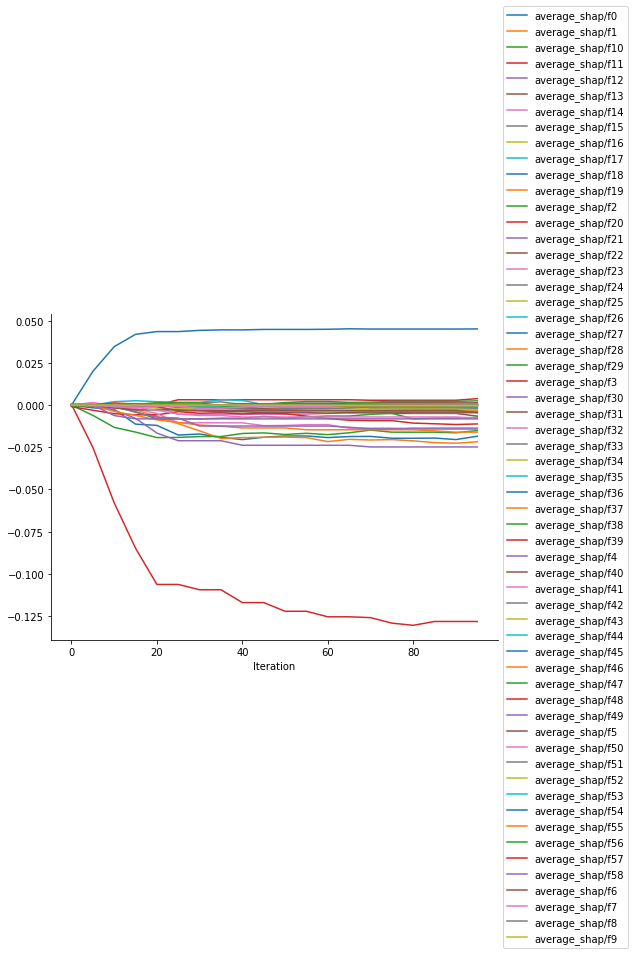

In [74]:
plot_collection(trial,"average_shap")